I chose the LSTM model to predict NVDA stock prices because it's well-suited for capturing sequential patterns in time-series data. LSTM's ability to remember and learn from past price movements allows it to effectively analyze historical stock data and make future predictions. This model excels at understanding the complex, non-linear relationships often found in stock prices, making it a reliable choice for forecasting in the financial market.


Data Source are downloaded from https://www.investing.com/equities/nvidia-corp-historical-data

# Data Loading and Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime
import glob
import os

2023-10-22 09:36:22.104329: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 09:36:22.137279: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 09:36:22.137324: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 09:36:22.137357: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 09:36:22.146748: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 09:36:22.147441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
# Function to create a DataFrame by concatenating multiple CSV files from a given directory
def create_df(data_dir):
    """
    Create a DataFrame by reading and consolidating data from CSV files in the given directory.

    Args:
        data_dir (str): Directory path containing CSV files.

    Returns:
        pd.DataFrame: Consolidated DataFrame with datetime index.
    """
    # List all CSV files in the directory
    file_list = glob.glob(os.path.join(data_dir, '*.csv'))
    data = []

    # Read and append data from each CSV file to create a consolidated DataFrame
    for file in file_list:
        df = pd.read_csv(file)
        data.append(df)

    # Concatenate the data from all CSV files
    df = pd.concat(data)

    # Set the "Date" column to a datetime format, handling different date formats
    if df["Date"].str.contains("/").any():
        try:
            df["Date"] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
        except ValueError:
            df["Date"] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
    elif df["Date"].str.contains(",").any():
        df["Date"] = pd.to_datetime(df["Date"], format="%b %d, %Y")

    # Sort the DataFrame by the "Date" column
    df = df.sort_values(by="Date")

    # Clean the data and set the "Date" column as the index
    df = df.drop(columns=["Change %","Open","High","Low", "Vol."])
    df = df.set_index("Date")

    # Resample the data to fill missing dates and reset the index
    df = df.resample('D').ffill()
    df = df.reset_index()

    # Convert the "Price" column to float type, handling comma-separated values
    if df["Price"].dtypes == object :
      df["Price"] = df["Price"].str.replace(",","").astype(np.float64)

    # Apply a logarithmic transformation to the "Price" column
    df["Price"] = np.log(df["Price"])

    return df

In [4]:
# Load data
df = create_df(r"/workspaces/Fintech-Society/NVDA Historical Data")
df

,Date,Price
0,1999-01-25,-0.798508
1,1999-01-26,-0.867501
2,1999-01-27,-0.867501
3,1999-01-28,-0.867501
4,1999-01-29,-0.916291
...,...,...
9030,2023-10-16,6.133290
9031,2023-10-17,6.085365
9032,2023-10-18,6.044911
9033,2023-10-19,6.042657


In [5]:
# Initialize the MinMaxScaler for data scaling
scaler = MinMaxScaler()

# Function to split data into features and target
def split_features_target(dataframe,sequence_length):
  scaled_data = scaler.fit_transform(dataframe['Price'].values.reshape(-1, 1))
  X = []
  y = []
  for i in range(len(scaled_data) - sequence_length):
      X.append(scaled_data[i:i+sequence_length, 0])
      y.append(scaled_data[i+sequence_length, 0])

  X = np.array(X)
  y = np.array(y)
  return X,y

In [6]:
# Split data into features (X) and target (y) for training
sequence_length = 30 # You can adjust this value
X, y = split_features_target(df,30)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
# Build an LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
113/113 [==============================] - 5s 21ms/step - loss: 0.0075
Epoch 2/50
113/113 [==============================] - 2s 20ms/step - loss: 1.3422e-04
Epoch 3/50
113/113 [==============================] - 2s 20ms/step - loss: 1.2821e-04
Epoch 4/50
113/113 [==============================] - 2s 20ms/step - loss: 1.2487e-04
Epoch 5/50
113/113 [==============================] - 2s 20ms/step - loss: 1.2082e-04
Epoch 6/50
113/113 [==============================] - 2s 21ms/step - loss: 1.1713e-04
Epoch 7/50
113/113 [==============================] - 2s 21ms/step - loss: 1.1775e-04
Epoch 8/50
113/113 [==============================] - 2s 21ms/step - loss: 1.1226e-04
Epoch 9/50
113/113 [==============================] - 2s 20ms/step - loss: 1.1176e-04
Epoch 10/50
113/113 [==============================] - 2s 20ms/step - loss: 1.0310e-04
Epoch 11/50
113/113 [==============================] - 2s 20ms/step - loss: 1.0274e-04
Epoch 12/50
113/113 [==============================] - 2

In [9]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions to the original scale
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

57/57 [==============================] - 0s 5ms/step


In [10]:
# Evaluate the model using RMSE
from sklearn.metrics import mean_squared_error
import math

# Concatenate predictions and actual values for training and testing sets
all_predictions = np.concatenate((np.exp(train_predictions), np.exp(test_predictions)))
all_actual = np.concatenate((np.exp(y_train), np.exp(y_test)))

# Calculate the overall RMSE for the entire dataset
overall_rmse = math.sqrt(mean_squared_error(all_actual, all_predictions))

print(f"Overall RMSE: {overall_rmse:.4f}")

Overall RMSE: 85.1029


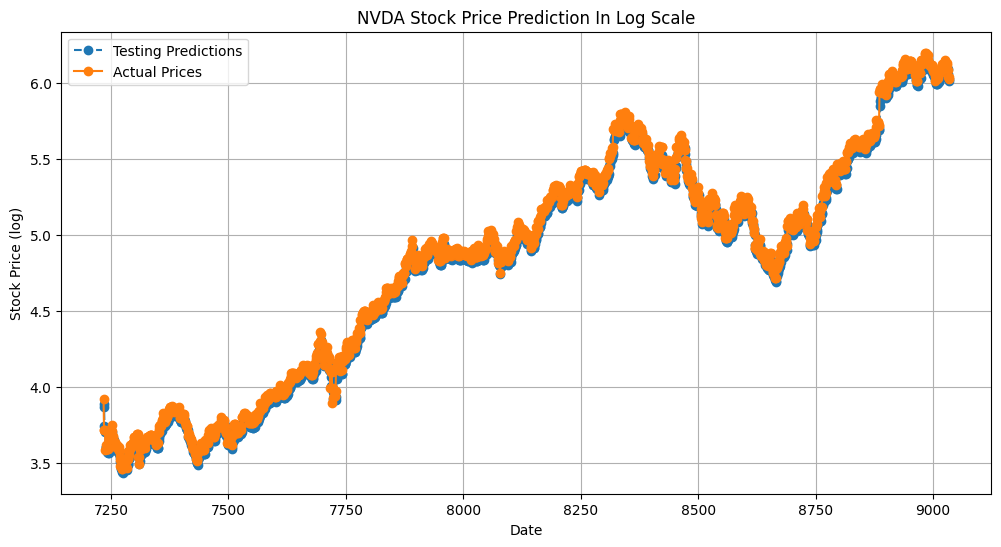

In [11]:
# Create a DataFrame with matching lengths for plotting
data_length = len(test_predictions)
df_pred = pd.DataFrame({
    'Date': df.index[-data_length:],
    'Testing Predictions': test_predictions.flatten(),
    'Actual Prices': df['Price'].tail(data_length)
})

# Create a line plot for visualizing the predictions
plt.figure(figsize=(12, 6))
plt.plot(df_pred['Date'], df_pred['Testing Predictions'], label='Testing Predictions', linestyle='--', marker='o')
plt.plot(df_pred['Date'], df_pred['Actual Prices'], label='Actual Prices', linestyle='-', marker='o')
plt.xlabel('Date')
plt.ylabel('Stock Price (log)')
plt.title('NVDA Stock Price Prediction In Log Scale')
plt.legend()
plt.grid(True)
plt.show()

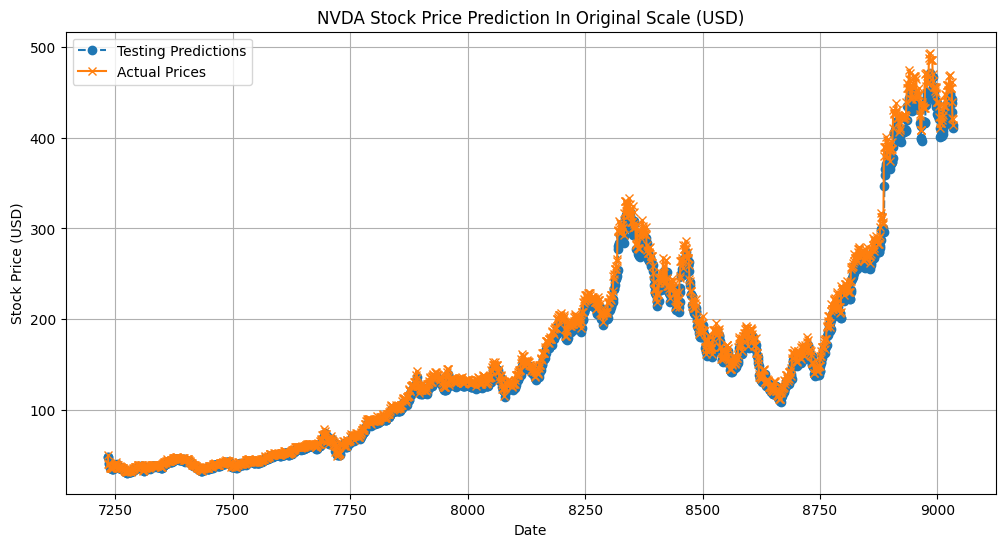

In [12]:
# Create a DataFrame with matching lengths for USD price plotting
data_length = len(test_predictions)
df_pred2 = pd.DataFrame({
    'Date': df.index[-data_length:],
    'Testing Predictions': np.exp(test_predictions.flatten()),
    'Actual Prices': np.exp(df['Price'].tail(data_length))
})

# Plot the predictions and actual prices using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df_pred2['Date'], df_pred2['Testing Predictions'], label='Testing Predictions', linestyle='--', marker='o')
plt.plot(df_pred2['Date'], df_pred2['Actual Prices'], label='Actual Prices', linestyle='-', marker='x')
plt.title("NVDA Stock Price Prediction In Original Scale (USD)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [13]:
# Create a copy of the original DataFrame to predict future prices
df_copy = df
forecast_period = 18

# Predict future stock prices day by day
for _ in range(forecast_period):
    # Get the last 30 days of data and scale it
    last_30_days = df_copy['Price'].tail(30).values.reshape(-1, 1)
    scaled_last_30_days = scaler.fit_transform(last_30_days)[0]

    # Make a prediction for the next day
    new_y = model.predict(np.array([scaled_last_30_days]))
    new_y = scaler.inverse_transform(new_y)

    # Calculate the date for the next day
    last_date = df_copy.iloc[-1, 0]
    new_date = last_date + pd.Timedelta(days=1)

    # Create a new DataFrame with the new date and predicted price
    new_df = pd.DataFrame({'Date': [new_date], 'Price': [new_y[0, 0]]})

    # Append the new data to the copy of the original DataFrame
    df_copy = pd.concat([df_copy, new_df], ignore_index=True)

1/1 [==============================] - 0s 15ms/step


In [14]:
# Convert the log-scaled prices back to USD
df_copy["Price"] = np.exp(df_copy["Price"])

In [52]:
# Display the predictions
predictions = df_copy.iloc[-14:].reset_index(drop=True)
predictions

,Date,Price
0,2023-10-25,415.378661
1,2023-10-26,413.951266
2,2023-10-27,416.513554
3,2023-10-28,419.381367
4,2023-10-29,421.263157
5,2023-10-30,421.263157
6,2023-10-31,421.263157
7,2023-11-01,426.979699
8,2023-11-02,421.345322
9,2023-11-03,423.717324


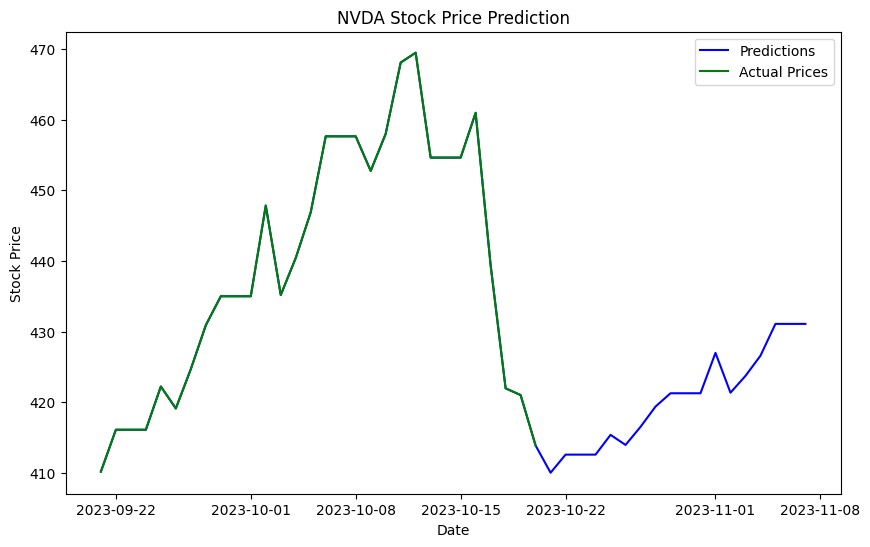

In [53]:
# Create a DataFrame with matching lengths for visualizing predictions
df_pred = pd.DataFrame({
    'Date': df_copy.iloc[-30-forecast_period:, 0],
    'Predictions': df_copy.iloc[-30-forecast_period:, 1],
    'Actual Prices': df_copy.iloc[-30-forecast_period:-forecast_period, 1]
})

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot Predictions
plt.plot(df_pred['Date'], df_pred['Predictions'], label='Predictions', color='blue')

# Plot Actual Prices
plt.plot(df_pred['Date'], df_pred['Actual Prices'], label='Actual Prices', color='green')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('NVDA Stock Price Prediction')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [54]:
# List of dates to remove
dates_to_remove = ["2023-10-28", "2023-10-29", "2023-11-04", "2023-11-05"]

# Use boolean indexing to keep rows with dates not in the list
predictions = predictions[~predictions['Date'].isin(dates_to_remove)]

# Display the filtered DataFrame
predictions.drop(columns=["Date"], inplace=True)

/tmp/ipykernel_15882/53627949.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions.drop(columns=["Date"], inplace=True)


In [57]:
# Change the column name to "Close"
predictions.columns = ["Close"]
# reset index and set the index name to "index"
predictions = predictions.reset_index(drop=True)
predictions.index.name = "index"

In [58]:
predictions

,Close
index,
0,415.378661
1,413.951266
2,416.513554
3,421.263157
4,421.263157
5,426.979699
6,421.345322
7,423.717324
8,431.079396


In [59]:
predictions.to_csv("HUA_SHIAO_HONG_Project_1.csv")